In [31]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report

In [32]:
def read_image_paths_and_labels(path):
    image_files = [f for f in os.listdir(path) if f.endswith('.jpg')]
    labels_file = os.path.join(path, "labels.csv")
    labels_df = pd.read_csv(labels_file)

    label_dict = dict(zip(labels_df['filename'], labels_df['label']))

    id_groups = {}

    for img_file in image_files:
        id_num = '_'.join(img_file.split('_')[:3])  

        if id_num not in id_groups:
            id_groups[id_num] = {}

        img_idx = int(img_file.split('_')[3].split('.')[0].replace('IMG', ''))
        img_path = os.path.join(path, img_file)

        id_groups[id_num][f"IMG{img_idx}"] = img_path  

    data = []
    for id_num, images in id_groups.items():
        if all(f"IMG{i}" in images for i in range(1, 6)):
            label_key = f"{id_num}_IMG1.jpg"
            row = {
                'ID': id_num,
                'Label': label_dict.get(label_key, None)
            }
            row.update(images)
            data.append(row)
        else:
            print(f"Skipping {id_num}: missing images")

    df = pd.DataFrame(data)
    return df

train_path = r"/home/furix/Desktop/DiscAI/data/Full Data (2)/train"
test_path = r"/home/furix/Desktop/DiscAI/data/Full Data (2)/test"
val_path = r"/home/furix/Desktop/DiscAI/data/Full Data (2)/val"

train_df = read_image_paths_and_labels(train_path)
test_df = read_image_paths_and_labels(test_path)
val_df = read_image_paths_and_labels(val_path)

print(len(train_df))

3071


In [ ]:
def resnet_block(input_tensor, filters, kernel_size=(3, 3), activation='relu', strides=(1, 1)):
    """
    A ResNet-style block.
    - 'filters': Number of filters in the convolutional layers of the main path.
    - 'strides': Strides for the first convolutional layer in the main path.
                 If strides > 1, downsampling occurs, and the shortcut is projected.
    - The shortcut connection is projected with a 1x1 convolution if:
        a) Strides > 1 (downsampling).
        b) The number of input channels does not match 'filters'.
    """
    x_main = input_tensor
    x_main = tf.keras.layers.Conv2D(filters, kernel_size, strides=strides, padding='same', activation=None)(x_main)
    x_main = tf.keras.layers.BatchNormalization()(x_main)
    x_main = tf.keras.layers.Activation(activation)(x_main)

    x_main = tf.keras.layers.Conv2D(filters, (5,5), strides=(1, 1), padding='same', activation=None)(x_main)
    x_main = tf.keras.layers.BatchNormalization()(x_main)

    shortcut = input_tensor
    input_channels = tf.keras.backend.int_shape(input_tensor)[-1]

    if strides != (1, 1) and strides != 1 or input_channels != filters:
        shortcut = tf.keras.layers.Conv2D(filters, (1, 1), strides=strides, padding='same', activation=None)(shortcut)
        shortcut = tf.keras.layers.BatchNormalization()(shortcut)
    
    output_tensor = tf.keras.layers.Add()([shortcut, x_main])
    output_tensor = tf.keras.layers.Activation(activation)(output_tensor)
    
    return output_tensor

def conv_block_with_residuals(input_tensor): 

    x = resnet_block(input_tensor, filters=16, strides=(1,1)) 
    x = tf.keras.layers.SpatialDropout2D(0.35)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x)


    x = resnet_block(x, filters=32, strides=(1,1))
    x = tf.keras.layers.SpatialDropout2D(0.35)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x) 


    x = resnet_block(x, filters=64, strides=(1,1)) 
    x = tf.keras.layers.SpatialDropout2D(0.35)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=2)(x) 
    
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.GlobalMaxPooling2D()(x) 

    return x

input_shape = (40, 80, 1)
inputs = [tf.keras.Input(input_shape, name=f"input_{i+1}") for i in range(5)] 

features = [conv_block_with_residuals(inp) for inp in inputs]

stacked_features = tf.keras.layers.Lambda(
    lambda x_list: tf.stack(x_list, axis=1),
    name='stack_features_lambda'
)(features)

attention_weights = tf.keras.layers.Dense(1, activation='tanh', name='attention_dense')(stacked_features)
attention_weights = tf.keras.layers.Softmax(axis=1, name='attention_softmax')(attention_weights)

attended_features = tf.keras.layers.Multiply(name='attention_multiply')([stacked_features, attention_weights])
attended_features = tf.keras.layers.Lambda(lambda x: tf.reduce_sum(x, axis=1), name='attention_reduce_sum')(attended_features)

x = tf.keras.layers.BatchNormalization()(attended_features)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.Dense(32, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.4)(x)

output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_2             │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_3             │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_4             │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_5             │ (None, 40, 80, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_180 (Conv2D) │ (None, 40, 80,    │        160 │ input_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_186 (Conv2D) │ (None, 40, 80,    │        160 │ input_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 40, 80,    │        160 │ input_3[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_198 (Conv2D) │ (None, 40, 80,    │        160 │ input_4[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 40, 80,    │        160 │ input_5[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80,    │         64 │ conv2d_180[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80,    │         64 │ conv2d_186[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80,    │         64 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80,    │         64 │ conv2d_198[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 80,    │         64 │ conv2d_204[0][0]  │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_120      │ (None, 40, 80,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_124      │ (None, 40, 80,    │          0 │ batch_normalizat

 Total params: 195,026 (761.82 KB)

 Trainable params: 193,202 (754.70 KB)

 Non-trainable params: 1,824 (7.12 KB)

In [ ]:
IMG_SIZE = (40, 80)

def load_and_process_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image


def process_sample(img_paths, label):
    images = tf.map_fn(
        load_and_process_image,
        img_paths,
        fn_output_signature=tf.TensorSpec(shape=(40, 80, 1), dtype=tf.float32)
    )
    img1, img2, img3, img4, img5 = tf.unstack(images, num=5, axis=0)
    return (img1, img2, img3, img4, img5), label


def build_dataset(df, batch_size=16, shuffle=True):
    img_paths = df[[f'IMG{i}' for i in range(1, 6)]].values
    labels = df['Label'].values.astype('float32')
    labels = labels.reshape(-1, 1)


    dataset = tf.data.Dataset.from_tensor_slices((img_paths, labels))
    dataset = dataset.map(lambda x, y: process_sample(x, y), num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


train_dataset = build_dataset(train_df)
val_dataset = build_dataset(val_df, shuffle=False)
test_dataset = build_dataset(test_df, shuffle=False)

checkpoint_filepath = 'best_model_checkpoint.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  
    monitor='val_loss',       
    mode='min',               
    save_best_only=True,     
    verbose=1                 
)



reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,              
    patience=5,              
    verbose=1,
    mode='min',
    min_lr=1e-6              
)

my_callbacks = [
    model_checkpoint_callback,
    reduce_lr_callback
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=my_callbacks,verbose=2 
)

print(f"Callbacks defined. Ensure your 'model' is defined and compiled.")
print(f"ModelCheckpoint will save to: {checkpoint_filepath}")
print("To view TensorBoard, run: tensorboard --logdir logs/fit")
print("\nReplace the placeholder model and data loading with your actual code, then uncomment the model.fit() call.")

Epoch 1/50

Epoch 1: val_loss improved from inf to 0.69108, saving model to best_model_checkpoint.keras
192/192 - 37s - 193ms/step - accuracy: 0.5373 - loss: 0.7376 - val_accuracy: 0.5575 - val_loss: 0.6911 - learning_rate: 1.0000e-03
Epoch 2/50

Epoch 2: val_loss improved from 0.69108 to 0.67045, saving model to best_model_checkpoint.keras
192/192 - 3s - 17ms/step - accuracy: 0.6001 - loss: 0.6640 - val_accuracy: 0.5575 - val_loss: 0.6705 - learning_rate: 1.0000e-03
Epoch 3/50

Epoch 3: val_loss improved from 0.67045 to 0.56189, saving model to best_model_checkpoint.keras
192/192 - 3s - 17ms/step - accuracy: 0.6776 - loss: 0.6019 - val_accuracy: 0.7914 - val_loss: 0.5619 - learning_rate: 1.0000e-03
Epoch 4/50

Epoch 4: val_loss improved from 0.56189 to 0.45262, saving model to best_model_checkpoint.keras
192/192 - 3s - 17ms/step - accuracy: 0.7382 - loss: 0.5258 - val_accuracy: 0.7623 - val_loss: 0.4526 - learning_rate: 1.0000e-03
Epoch 5/50

Epoch 5: val_loss improved from 0.45262 to

In [43]:
test_loss, test_accuracy = model.evaluate(test_dataset)

print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9077 - loss: 0.2385
Test loss: 0.27164462208747864
Test accuracy: 0.8915289044380188


In [42]:
y_pred_probs = model.predict(test_dataset)
y_pred = (y_pred_probs > 0.5).astype(int)

y_true = []
for _, labels in test_dataset:
    y_true.extend(labels.numpy())  

y_true = np.array(y_true)

f1 = f1_score(y_true, y_pred)
print("F1 Score:", f1)

print(classification_report(y_true, y_pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step
F1 Score: 0.8754448398576512
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.90       543
         1.0       0.88      0.87      0.88       425

    accuracy                           0.89       968
   macro avg       0.89      0.89      0.89       968
weighted avg       0.89      0.89      0.89       968



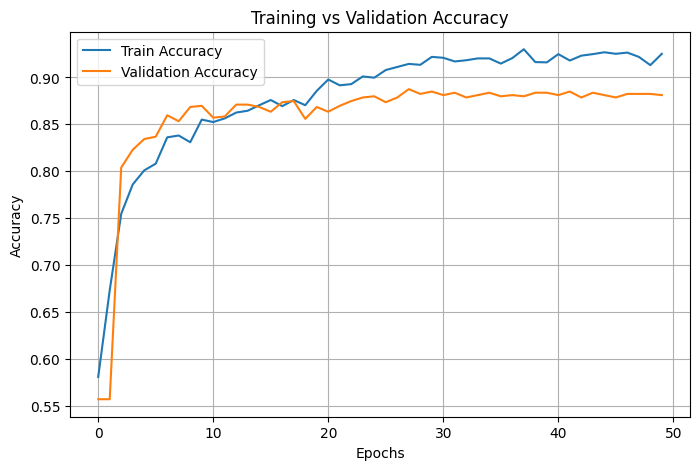

In [28]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

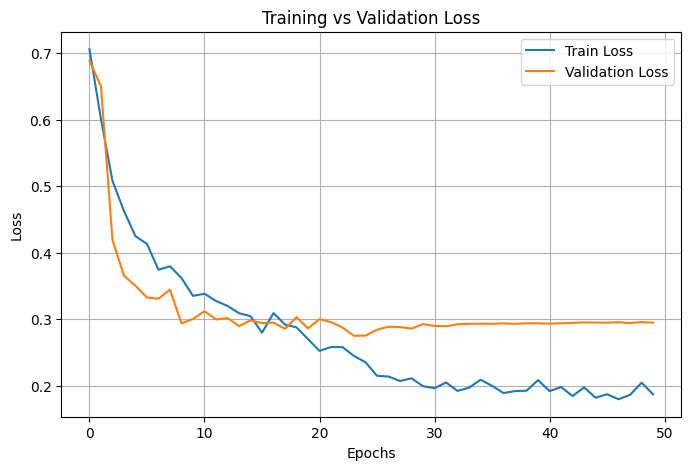

In [29]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [30]:
model.save("best_model.keras")
model.save_weights("best_weights.weights.h5")
model.export('classificaiton-best-till-now')

INFO:tensorflow:Assets written to: classificaiton-best-till-now/assets


INFO:tensorflow:Assets written to: classificaiton-best-till-now/assets


Saved artifact at 'classificaiton-best-till-now'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 40, 80, 1), dtype=tf.float32, name='input_1'), TensorSpec(shape=(None, 40, 80, 1), dtype=tf.float32, name='input_2'), TensorSpec(shape=(None, 40, 80, 1), dtype=tf.float32, name='input_3'), TensorSpec(shape=(None, 40, 80, 1), dtype=tf.float32, name='input_4'), TensorSpec(shape=(None, 40, 80, 1), dtype=tf.float32, name='input_5')]
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139155008419472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139155008416304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139154456962048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139154456953248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139154448328208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139154454243184: TensorSpec(shape=(), dtype=tf.resource, name=None)
 